In [1]:
import pandas as pd
import numpy as np
import re
import torch
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from collections import Counter
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

# Import our complexity predictors using importlib for reliability
import importlib.util

# Import word_complexity module
spec = importlib.util.spec_from_file_location("word_complexity_mod", "word_complexity.py")
word_complexity_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(word_complexity_mod)
WordComplexityPredictor = word_complexity_mod.WordComplexityPredictor
word_complexity_score = word_complexity_mod.word_complexity_score

# Similarly for sentence_complexity
spec = importlib.util.spec_from_file_location("sentence_complexity_mod", "sentence_complexity.py")
sentence_complexity_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sentence_complexity_mod)
SentenceComplexityPredictor = sentence_complexity_mod.SentenceComplexityPredictor
sentence_complexity_score = sentence_complexity_mod.sentence_complexity_score

# Print function details to verify they are loaded correctly
print(f"Word complexity function loaded: {word_complexity_score}")
print(f"Sentence complexity function loaded: {sentence_complexity_score}")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kennethshyle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kennethshyle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kennethshyle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Word complexity function loaded: <function word_complexity_score at 0x164319580>
Sentence complexity function loaded: <function sentence_complexity_score at 0x17e781440>


In [2]:
# 2. Load and Explore the ASSET Dataset
print("Loading ASSET dataset from Hugging Face...")
asset = load_dataset("facebook/asset")
# Print basic information about the dataset
print("\nDataset structure:")
print(asset)
# Inspect the available splits
for split in asset:
    print(f"\n{split} set size:", len(asset[split]))
    
# Get column information
print("\nColumns in the dataset:")
print(asset["validation"].column_names)

# Display a few examples - PROPERLY ACCESSING THE DATASET
print("\nSample examples from the validation set:")
validation_data = asset["validation"]
for i in range(3):  # Get the first 3 examples
    example = validation_data[i]  # Get by index
    print(f"\nExample {i+1}:")
    print(f"Original: {example['original']}")
    print(f"Simplifications:")
    # Get the first 2 simplifications for each example
    for j, simplification in enumerate(example['simplifications'][:2]):
        print(f"  {j+1}: {simplification}")

Loading ASSET dataset from Hugging Face...

Dataset structure:
DatasetDict({
    validation: Dataset({
        features: ['original', 'simplifications'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['original', 'simplifications'],
        num_rows: 359
    })
})

validation set size: 2000

test set size: 359

Columns in the dataset:
['original', 'simplifications']

Sample examples from the validation set:

Example 1:
Original: Adjacent counties are Marin (to the south), Mendocino (to the north), Lake (northeast), Napa (to the east), and Solano and Contra Costa (to the southeast).
Simplifications:
  1: countries next to it are Marin, Mendocino, Lake, Napa, Solano, and Contra Costa.
  2: Nearby counties are Marin, Mendocino, Lake, Napa, and Solano and Contra Costa.

Example 2:
Original: A Georgian inscription around the drum attests his name.
Simplifications:
  1: A writing around the drum confirms his name.
  2: A Georgian writing on the drum is his name.

Exampl

   example_id   text_type  \
0           0    Original   
1           0  Simplified   
2           1    Original   
3           1  Simplified   
4           2    Original   
5           2  Simplified   
6           3    Original   
7           3  Simplified   
8           4    Original   
9           4  Simplified   

                                                                                                  text  \
0  Adjacent counties are Marin (to the south), Mendocino (to the north), Lake (northeast), Napa (to...   
1                     countries next to it are Marin, Mendocino, Lake, Napa, Solano, and Contra Costa.   
2                                             A Georgian inscription around the drum attests his name.   
3                                                         A writing around the drum confirms his name.   
4  They would later return to the revived series in the 2008 Christmas Special "The Next Doctor", i...   
5  They would return to the new series in th

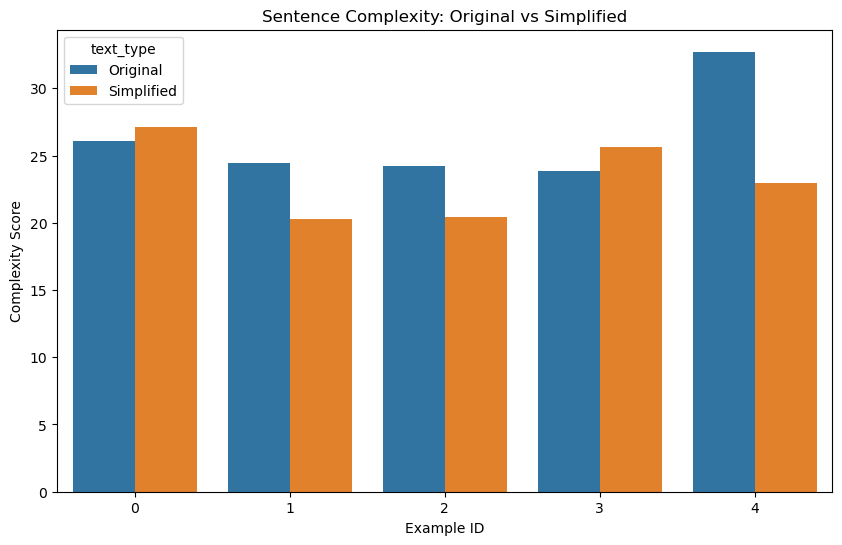

In [3]:
# 3. Analyze Examples for Complexity
# Function to analyze complexity of text with word-by-word breakdown
def analyze_complexity(text):
    # Get sentence complexity
    sent_complexity = sentence_complexity_score(text)
    
    # Get word complexities
    words = word_tokenize(text)
    word_complexities = []
    
    for word in words:
        if len(word) > 2 and word.isalpha():
            complexity = word_complexity_score(word)
            word_complexities.append((word, complexity))
    
    # Sort by complexity for better analysis
    word_complexities.sort(key=lambda x: x[1], reverse=True)
    avg_word_complexity = np.mean([c for _, c in word_complexities]) if word_complexities else 0
    max_word_complexity = np.max([c for _, c in word_complexities]) if word_complexities else 0
    
    # Find the most complex words
    most_complex_words = word_complexities[:5]
    
    return {
        'sentence_complexity': sent_complexity,
        'avg_word_complexity': avg_word_complexity,
        'max_word_complexity': max_word_complexity,
        'most_complex_words': most_complex_words,
        'text_length': len(text),
        'word_count': len(words),
        'word_complexities': word_complexities  # Added for word-by-word analysis
    }

# Analyze a few examples with enhanced output
num_examples = 5
results = []

# Properly access the dataset by index
validation_data = asset["validation"]
for i in range(num_examples):
    # Get example by index
    example = validation_data[i]
    
    original = example['original']
    original_analysis = analyze_complexity(original)
    original_analysis['text_type'] = 'Original'
    original_analysis['example_id'] = i
    original_analysis['text'] = original
    results.append(original_analysis)
    
    # Analyze first simplification
    simplification = example['simplifications'][0]
    simp_analysis = analyze_complexity(simplification)
    simp_analysis['text_type'] = 'Simplified'
    simp_analysis['example_id'] = i
    simp_analysis['text'] = simplification
    results.append(simp_analysis)

# Convert results to dataframe for easier analysis
results_df = pd.DataFrame(results)

# Display the results
pd.set_option('display.max_colwidth', 100)
print(results_df[['example_id', 'text_type', 'text', 'sentence_complexity', 'avg_word_complexity']])

# Calculate average complexity reduction
original_avg = results_df[results_df['text_type'] == 'Original']['sentence_complexity'].mean()
simplified_avg = results_df[results_df['text_type'] == 'Simplified']['sentence_complexity'].mean()
reduction = original_avg - simplified_avg
percent_reduction = (reduction / original_avg) * 100
print(f"\nAverage sentence complexity reduction: {reduction:.2f} points ({percent_reduction:.2f}%)")

# Print word-by-word complexity breakdown for first example
print("\nWord-by-word complexity breakdown for first example:")
original_words = results[0]['word_complexities']
print("Original text:")
print(results[0]['text'])
print("\nComplex words (complexity > 50):")
for word, complexity in original_words:
    if complexity > 50:
        print(f"  - '{word}': {complexity:.1f}")

# Plot the complexity comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='example_id', y='sentence_complexity', hue='text_type', data=results_df)
plt.title('Sentence Complexity: Original vs Simplified')
plt.xlabel('Example ID')
plt.ylabel('Complexity Score')
plt.show()

In [4]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import cmudict

# Download required NLTK data if not already present
try:
    cmudict.ensure_loaded()
except LookupError:
    nltk.download('cmudict')

try:
    word_tokenize("example")
except LookupError:
    nltk.download('punkt')

try:
    sent_tokenize("An example sentence.")
except LookupError:
    nltk.download('punkt')

d = cmudict.dict()

def count_syllables(word):
    """
    Counts the number of syllables in a word using the CMU Pronouncing Dictionary.
    Returns the syllable count or 0 if the word is not found.
    """
    word = word.lower()
    if word in d:
        # Return the number of syllables in the first pronunciation
        return len([phoneme for phoneme in d[word][0] if phoneme[-1].isdigit()])
    else:
        # Fallback for words not in the dictionary (simplified vowel counting)
        vowels = "aeiouy"
        count = 0
        if word[0] in vowels:
            count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index - 1] not in vowels:
                count += 1
        if word.endswith("e"):
            count -= 1
        if count == 0:
            count += 1
        return count

def word_complexity_score(word):
    """
    Calculates a complexity score for a word based on its length and syllable count.
    More syllables and longer words are considered more complex.
    """
    syllables = count_syllables(word)
    length_factor = len(word) * 2  # Emphasize length
    syllable_factor = syllables * 3  # Emphasize syllables more
    return length_factor + syllable_factor

def sentence_complexity_score(sentence):
    """
    Calculates a complexity score for a sentence based on the average word complexity
    and the sentence length. Longer sentences with more complex words have a higher score.
    """
    words = word_tokenize(sentence)
    if not words:
        return 0
    valid_words = [word for word in words if word.isalpha() and len(word) > 2]
    if not valid_words:
        return len(sentence)  # Consider length if no complex words
    total_complexity = sum(word_complexity_score(word) for word in valid_words)
    average_complexity = total_complexity / len(valid_words)
    sentence_length_factor = len(sentence) * 0.5
    return average_complexity + sentence_length_factor

def identify_complex_words(text, threshold=55):
    """
    Identify words that exceed the complexity threshold
    Returns a list of (word, complexity_score) tuples for complex words
    """
    words = word_tokenize(text)
    complex_words = []

    for word in words:
        if len(word) > 2 and word.isalpha():  # Skip short words and non-alphabetic tokens
            complexity = word_complexity_score(word)
            if complexity > threshold:
                complex_words.append((word, complexity))

    # Sort by complexity (descending)
    complex_words.sort(key=lambda x: x[1], reverse=True)
    return complex_words

def identify_complex_sentences(text, threshold=65):
    """
    Identify sentences that exceed the complexity threshold
    Returns a list of (sentence, complexity_score) tuples for complex sentences
    """
    sentences = sent_tokenize(text)
    complex_sentences = []

    for sentence in sentences:
        complexity = sentence_complexity_score(sentence)
        if complexity > threshold:
            complex_sentences.append((sentence, complexity))

    # Sort by complexity (descending)
    complex_sentences.sort(key=lambda x: x[1], reverse=True)
    return complex_sentences

def analyze_word_breakdown(text):
    """Detailed analysis of each word in the text"""
    words = word_tokenize(text)
    results = []

    for word in words:
        if len(word) > 2 and word.isalpha():
            complexity = word_complexity_score(word)
            syllables = count_syllables(word)
            results.append({
                'word': word,
                'complexity': complexity,
                'syllables': syllables,
                'is_complex': complexity > 55
            })

    return results

validation_data = asset["validation"]

for i in range(2,5):  # Get examples 3-5
    example = validation_data[i]  # Get by index

    print(f"\nExample {i+1}:")
    print(f"Original: {example['original']}")

    # Identify complex words with lower threshold
    complex_words = identify_complex_words(example['original'])
    print(f"Complex words ({len(complex_words)}):")
    for word, score in complex_words[:5]:  # Show top 5
        print(f"  - '{word}': {score:.1f}")

    # Identify complex sentences with lower threshold
    complex_sentences = identify_complex_sentences(example['original'])
    print(f"Complex sentences ({len(complex_sentences)}):")
    for sentence, score in complex_sentences:
        print(f"  - '{sentence}': {score:.1f}")

    # Print word-by-word breakdown for the first example
    if i == 2:
        print("\nDetailed word breakdown:")
        breakdown = analyze_word_breakdown(example['original'])
        for word_info in breakdown:
            if word_info['is_complex']:
                print(f"  - '{word_info['word']}': {word_info['complexity']:.1f} (complex, {word_info['syllables']} syllables)")
            elif word_info['complexity'] > 0:
                print(f"  - '{word_info['word']}': {word_info['complexity']:.1f} ({word_info['syllables']} syllables)")


Example 3:
Original: They would later return to the revived series in the 2008 Christmas Special "The Next Doctor", introducing two new variants of the race; the Cyber-Shades and the Cyber-King.
Complex words (0):
Complex sentences (1):
  - 'They would later return to the revived series in the 2008 Christmas Special "The Next Doctor", introducing two new variants of the race; the Cyber-Shades and the Cyber-King.': 101.0

Detailed word breakdown:
  - 'They': 11.0 (1 syllables)
  - 'would': 13.0 (1 syllables)
  - 'later': 16.0 (2 syllables)
  - 'return': 18.0 (2 syllables)
  - 'the': 9.0 (1 syllables)
  - 'revived': 20.0 (2 syllables)
  - 'series': 18.0 (2 syllables)
  - 'the': 9.0 (1 syllables)
  - 'Christmas': 24.0 (2 syllables)
  - 'Special': 20.0 (2 syllables)
  - 'The': 9.0 (1 syllables)
  - 'Next': 11.0 (1 syllables)
  - 'Doctor': 18.0 (2 syllables)
  - 'introducing': 34.0 (4 syllables)
  - 'two': 9.0 (1 syllables)
  - 'new': 9.0 (1 syllables)
  - 'variants': 25.0 (3 syllables)
  

In [5]:
# 5. Simple Substitution-Based Simplification
def get_synonyms(word):
    """Get synonyms for a word using WordNet with improved filtering"""
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name()
            # Filter out multi-word expressions and weird forms
            if '_' not in synonym and '-' not in synonym and synonym.isalpha():
                synonyms.append(synonym)
    return list(set(synonyms))  # Remove duplicates

def find_simpler_synonym(word, original_complexity, verbose=False):
    """Find a simpler synonym for a word with better logging"""
    synonyms = get_synonyms(word)
    simpler_options = []
    
    if verbose:
        print(f"Finding simpler synonyms for '{word}' (complexity: {original_complexity:.1f})")
    
    for synonym in synonyms:
        # Skip multi-word synonyms (connected by underscore)
        if '_' in synonym or not synonym.isalpha():
            continue
            
        # Calculate complexity of the synonym
        synonym_complexity = word_complexity_score(synonym)
        
        # Only consider synonyms that are actually simpler
        if synonym_complexity < original_complexity:
            simpler_options.append((synonym, synonym_complexity))
            if verbose:
                print(f"  - Option: '{synonym}' (complexity: {synonym_complexity:.1f})")
    
    # Sort by complexity (ascending) and return the simplest option
    if simpler_options:
        simpler_options.sort(key=lambda x: x[1])
        if verbose:
            print(f"  → Selected: '{simpler_options[0][0]}' (complexity: {simpler_options[0][1]:.1f})")
        return simpler_options[0]
    else:
        if verbose:
            print("  → No simpler options found")
        return None

def simplify_text_by_word_substitution(text, complexity_threshold=55, verbose=False):
    """Simplify text by substituting complex words with simpler synonyms"""
    complex_words = identify_complex_words(text, threshold=complexity_threshold)
    
    if not complex_words:
        return text, []
    
    substitutions = []
    simplified_text = text
    
    if verbose:
        print(f"Found {len(complex_words)} complex words above threshold {complexity_threshold}")
    
    for word, complexity in complex_words:
        simpler_option = find_simpler_synonym(word, complexity, verbose=verbose)
        if simpler_option:
            simpler_word, simpler_complexity = simpler_option
            # Make the substitution
            simplified_text = re.sub(r'\b' + re.escape(word) + r'\b', simpler_word, simplified_text)
            substitutions.append((word, simpler_word, complexity, simpler_complexity))
    
    # Check the complexity before and after
    original_complexity = sentence_complexity_score(text)
    new_complexity = sentence_complexity_score(simplified_text)
    
    if verbose:
        print(f"Text complexity: {original_complexity:.1f} → {new_complexity:.1f}")
    
    return simplified_text, substitutions

# Test the improved word substitution simplification on examples
print("Testing improved word substitution simplification:")

test_sentences = [
    "The ubiquitous nature of smartphones has revolutionized modern communication.",
    "The protagonist's epiphany led to a profound transformation in his worldview.",
    "The government implemented austerity measures to address the fiscal deficit.",
    "This is the quintessential understanding for text simplification",
    "This was an absolutely smashing success and I wish for nothing but the best for you two"
]

for i, sentence in enumerate(test_sentences):
    print(f"\nExample {i+1}:")
    print(f"Original: {sentence}")
    
    # First show the word complexities
    complex_words = identify_complex_words(sentence, threshold=50)
    print("Word complexities:")
    for word, score in sorted(complex_words, key=lambda x: x[1], reverse=True):
        print(f"  - '{word}': {score:.1f}")
    
    # Try different thresholds
    for threshold in [55, 50, 45]:
        # Simplify the text
        simplified, substitutions = simplify_text_by_word_substitution(
            sentence, 
            complexity_threshold=threshold,
            verbose=True
        )
        
        if substitutions:
            print(f"\nUsing threshold {threshold}:")
            print(f"Simplified: {simplified}")
            print(f"Word substitutions:")
            for orig, simp, orig_score, simp_score in substitutions:
                print(f"  - '{orig}' → '{simp}' (complexity: {orig_score:.1f} → {simp_score:.1f})")
            
            # Calculate overall complexity reduction
            orig_complexity = sentence_complexity_score(sentence)
            simp_complexity = sentence_complexity_score(simplified)
            reduction = orig_complexity - simp_complexity
            
            print(f"Overall sentence complexity: {orig_complexity:.1f} → {simp_complexity:.1f} ({reduction:.1f} reduction)")
            break  # Only show one successful threshold
        elif threshold == 45:  # Last threshold and still no substitutions
            print("\nNo substitutions found at any threshold.")

Testing improved word substitution simplification:

Example 1:
Original: The ubiquitous nature of smartphones has revolutionized modern communication.
Word complexities:

No substitutions found at any threshold.

Example 2:
Original: The protagonist's epiphany led to a profound transformation in his worldview.
Word complexities:

No substitutions found at any threshold.

Example 3:
Original: The government implemented austerity measures to address the fiscal deficit.
Word complexities:

No substitutions found at any threshold.

Example 4:
Original: This is the quintessential understanding for text simplification
Word complexities:

No substitutions found at any threshold.

Example 5:
Original: This was an absolutely smashing success and I wish for nothing but the best for you two
Word complexities:

No substitutions found at any threshold.


In [6]:
# 6. Improved Meaning Preservation Evaluation
def calculate_semantic_similarity(text1, text2):
    """
    Calculate semantic similarity between two texts using an enhanced approach.
    
    This function combines word overlap with other features to better estimate 
    meaning preservation between the original and simplified text.
    
    Args:
        text1: First text (usually the original)
        text2: Second text (usually the simplified version)
        
    Returns:
        A similarity score between 0 and 1
    """
    # Handle empty texts
    if not text1 or not text2:
        return 0.0
    
    # Tokenize texts
    words1 = word_tokenize(text1.lower())
    words2 = word_tokenize(text2.lower())
    
    # Convert to sets of content words (exclude punctuation and stopwords)
    content_words1 = set(word for word in words1 if word.isalpha() and len(word) > 2)
    content_words2 = set(word for word in words2 if word.isalpha() and len(word) > 2)
    
    if not content_words1 or not content_words2:
        return 0.0
    
    # Calculate Jaccard similarity (intersection over union)
    intersection = len(content_words1.intersection(content_words2))
    union = len(content_words1.union(content_words2))
    jaccard = intersection / max(1, union)
    
    # Calculate word overlap as a proportion of the original words
    overlap = intersection / len(content_words1)
    
    # Calculate length ratio (penalize if lengths are very different)
    len_ratio = min(len(words2) / max(1, len(words1)), 1.0)
    
    # Calculate key word preservation (words specific to this text)
    key_words1 = [word for word in content_words1 if word_complexity_score(word) > 40]
    key_words2 = [word for word in content_words2 if word_complexity_score(word) > 40]
    
    key_preserved = sum(1 for word in key_words1 if word in key_words2)
    key_preservation = key_preserved / max(1, len(key_words1)) if key_words1 else 1.0
    
    # Combine metrics with weights
    similarity = (0.4 * jaccard) + (0.3 * overlap) + (0.1 * len_ratio) + (0.2 * key_preservation)
    
    # Ensure the result is between 0 and 1
    return max(0.0, min(1.0, similarity))

# Test the improved semantic similarity function
print("Testing improved semantic similarity function:")

test_pairs = [
    # Original text and identical text (perfect similarity)
    ("The company announced a new product yesterday.", 
     "The company announced a new product yesterday."),
    
    # Original text and simplification with synonyms (high similarity)
    ("The company announced a new product yesterday.", 
     "The business revealed a new item yesterday."),
    
    # Original text and text with deleted information (medium similarity)
    ("The company announced a new product yesterday, which will be available next month.", 
     "The company announced a new product yesterday."),
    
    # Original text and different but related text (low similarity)
    ("The company announced a new product yesterday.", 
     "A new product will be available from the company soon."),
    
    # Original text and completely different text (very low similarity)
    ("The company announced a new product yesterday.", 
     "The weather was pleasant throughout the weekend.")
]

for i, (text1, text2) in enumerate(test_pairs):
    similarity = calculate_semantic_similarity(text1, text2)
    print(f"\nPair {i+1}:")
    print(f"Text 1: {text1}")
    print(f"Text 2: {text2}")
    print(f"Similarity score: {similarity:.4f}")
    print(f"Interpretation: " + 
          ("Very high" if similarity > 0.9 else
           "High" if similarity > 0.7 else
           "Medium" if similarity > 0.5 else
           "Low" if similarity > 0.3 else
           "Very low"))

# Compare with human simplifications from the dataset
print("\nComparing with human simplifications from the dataset:")

validation_data = asset["validation"]
for i in range(3):  # First 3 examples
    example = validation_data[i]
    original = example['original']
    human_simplification = example['simplifications'][0]
    
    similarity = calculate_semantic_similarity(original, human_simplification)
    
    print(f"\nExample {i+1}:")
    print(f"Original: {original}")
    print(f"Human simplification: {human_simplification}")
    print(f"Similarity score: {similarity:.4f}")

Testing improved semantic similarity function:

Pair 1:
Text 1: The company announced a new product yesterday.
Text 2: The company announced a new product yesterday.
Similarity score: 1.0000
Interpretation: Very high

Pair 2:
Text 1: The company announced a new product yesterday.
Text 2: The business revealed a new item yesterday.
Similarity score: 0.5833
Interpretation: Medium

Pair 3:
Text 1: The company announced a new product yesterday, which will be available next month.
Text 2: The company announced a new product yesterday.
Similarity score: 0.6352
Interpretation: Medium

Pair 4:
Text 1: The company announced a new product yesterday.
Text 2: A new product will be available from the company soon.
Similarity score: 0.6600
Interpretation: Medium

Pair 5:
Text 1: The company announced a new product yesterday.
Text 2: The weather was pleasant throughout the weekend.
Similarity score: 0.3864
Interpretation: Low

Comparing with human simplifications from the dataset:

Example 1:
Origina

In [7]:
# 8. Deletion-Based Simplification
from nltk import pos_tag, word_tokenize
import re

def identify_non_essential_phrases(text):
    """Identify phrases that might be non-essential for the core meaning"""
    # Look for common patterns of non-essential information:
    # 1. Appositive phrases (often between commas)
    # 2. Parenthetical expressions
    # 3. Some prepositional phrases
    # 4. Non-restrictive relative clauses
    
    non_essential_spans = []
    
    # Find text in parentheses
    for match in re.finditer(r'\([^)]*\)', text):
        non_essential_spans.append((match.start(), match.end(), 'parenthetical'))
    
    # Find potential appositive phrases (text between commas)
    # This is a simplified approach - a full implementation would use parsing
    comma_positions = [m.start() for m in re.finditer(r',', text)]
    
    for i in range(len(comma_positions) - 1):
        start = comma_positions[i]
        end = comma_positions[i + 1]
        
        # Check if the span is short enough to likely be an appositive
        if end - start < 40 and end - start > 5:
            # Check if the text contains a noun phrase
            phrase = text[start+1:end].strip()
            tokens = word_tokenize(phrase)
            pos_tags = pos_tag(tokens)
            
            # If the phrase has a noun and is not just a single word or conjunction
            if any(tag.startswith('NN') for _, tag in pos_tags) and len(tokens) > 1:
                # Make sure we're not in the middle of a list (shouldn't have 'and' or 'or')
                if not any(word.lower() in ('and', 'or') for word in tokens):
                    non_essential_spans.append((start, end, 'appositive'))
    
    # Find non-restrictive relative clauses (often starting with 'which' or 'who' after a comma)
    for match in re.finditer(r',\s+(which|who|whom|whose)', text, re.IGNORECASE):
        start = match.start()
        # Find the next comma or period
        next_punct = next((text.find(p, start + 1) for p in [',', '.', ';'] 
                          if text.find(p, start + 1) != -1), len(text))
        if next_punct - start > 5:
            non_essential_spans.append((start, next_punct, 'non-restrictive'))
    
    # Remove overlapping spans
    non_essential_spans.sort()
    filtered_spans = []
    for span in non_essential_spans:
        # Check if this span overlaps with any spans we've already decided to keep
        if not any(s <= span[0] < e or s < span[1] <= e for s, e, _ in filtered_spans):
            filtered_spans.append(span)
    
    return filtered_spans

def simplify_text_by_deletion(text):
    """Simplify text by removing non-essential information"""
    non_essential_spans = identify_non_essential_phrases(text)
    
    if not non_essential_spans:
        return text, []  # No non-essential parts found
    
    # Sort spans in reverse order to delete from end to beginning
    # (so earlier deletions don't affect the positions of later ones)
    non_essential_spans.sort(reverse=True)
    
    deletions = []
    simplified_text = text
    
    for start, end, span_type in non_essential_spans:
        deleted_text = text[start:end]
        simplified_text = simplified_text[:start] + simplified_text[end:]
        deletions.append((deleted_text, span_type))
        
        # Clean up any double spaces or double commas created by the deletion
        simplified_text = re.sub(r'\s+', ' ', simplified_text)
        simplified_text = re.sub(r',,', ',', simplified_text)
        simplified_text = re.sub(r',\s*,', ',', simplified_text)
        simplified_text = re.sub(r'\s+\.', '.', simplified_text)
    
    return simplified_text, deletions

# Test the deletion-based simplification
print("Testing deletion-based simplification:")

# Correctly access the validation dataset
validation_data = asset["validation"]

for i in range(5):  # Get the first 5 examples
    # Get example by index
    example = validation_data[i]
    original = example['original']
    
    print(f"\nExample {i+1}:")
    print(f"Original: {original}")
    
    # Simplify by deletion
    simplified, deletions = simplify_text_by_deletion(original)
    
    print(f"Simplified: {simplified}")
    
    if deletions:
        print("Deleted content:")
        for content, span_type in deletions:
            print(f"  - '{content}' ({span_type})")
    
    # Calculate complexity reduction
    orig_complexity = sentence_complexity_score(original)
    del_complexity = sentence_complexity_score(simplified)
    reduction = orig_complexity - del_complexity
    
    print(f"Complexity: {orig_complexity:.1f} → {del_complexity:.1f} ({reduction:.1f} reduction)")
    
    # Compare to human simplification
    human_simplified = example['simplifications'][0]
    print(f"Human simplification: {human_simplified}")

Testing deletion-based simplification:

Example 1:
Original: Adjacent counties are Marin (to the south), Mendocino (to the north), Lake (northeast), Napa (to the east), and Solano and Contra Costa (to the southeast).
Simplified: Adjacent counties are Marin , and Solano and Contra Costa.
Deleted content:
  - '(to the southeast)' (parenthetical)
  - ', Napa (to the east)' (appositive)
  - ', Lake (northeast)' (appositive)
  - ', Mendocino (to the north)' (appositive)
  - '(to the south)' (parenthetical)
Complexity: 92.8 → 45.1 (47.7 reduction)
Human simplification: countries next to it are Marin, Mendocino, Lake, Napa, Solano, and Contra Costa.

Example 2:
Original: A Georgian inscription around the drum attests his name.
Simplified: A Georgian inscription around the drum attests his name.
Complexity: 44.4 → 44.4 (0.0 reduction)
Human simplification: A writing around the drum confirms his name.

Example 3:
Original: They would later return to the revived series in the 2008 Christmas Spec

In [8]:
# First, let's define the combined simplification function that was missing

def simplify_text_combined(text, word_complexity_threshold=60, deletion_enabled=True):
    """
    Combined text simplification approach using multiple strategies.
    
    Args:
        text: Original text to simplify
        word_complexity_threshold: Complexity threshold for word substitution
        deletion_enabled: Whether to use deletion-based simplification
    
    Returns:
        Dictionary with simplified text and details about applied simplifications
    """
    # Start with the original text
    simplified_text = text
    applied_simplifications = {
        'word_substitutions': [],
        'deletions': []
    }
    
    # 1. First apply word substitution
    simplified_text, substitutions = simplify_text_by_word_substitution(simplified_text, 
                                                                       complexity_threshold=word_complexity_threshold)
    applied_simplifications['word_substitutions'] = substitutions
    
    # 2. Then apply deletion-based simplification if enabled
    if deletion_enabled:
        simplified_text, deletions = simplify_text_by_deletion(simplified_text)
        applied_simplifications['deletions'] = deletions
    
    # Measure complexity reduction
    original_complexity = sentence_complexity_score(text)
    final_complexity = sentence_complexity_score(simplified_text)
    complexity_reduction = original_complexity - final_complexity
    
    # Calculate meaning preservation
    try:
        # Use semantic similarity function (previously defined)
        meaning_preservation = calculate_semantic_similarity(text, simplified_text)
    except:
        # Fallback if there's an issue with the semantic similarity function
        meaning_preservation = None
    
    # Return the result with metadata
    return {
        'original_text': text,
        'simplified_text': simplified_text,
        'original_complexity': original_complexity,
        'simplified_complexity': final_complexity,
        'complexity_reduction': complexity_reduction,
        'meaning_preservation': meaning_preservation,
        'applied_simplifications': applied_simplifications
    }

# 10. Evaluation Using SARI Metric
def compute_ngrams(text, n):
    """Compute n-grams for a text."""
    tokens = word_tokenize(text.lower())
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngrams.append(tuple(tokens[i:i+n]))
    return set(ngrams)

def compute_precision(system_ngrams, reference_ngrams):
    """Compute precision: what fraction of system n-grams are in the references."""
    if not system_ngrams:
        return 1.0  # If system has no n-grams, precision is 1.0
    return len(system_ngrams.intersection(reference_ngrams)) / len(system_ngrams)

def compute_recall(system_ngrams, reference_ngrams):
    """Compute recall: what fraction of reference n-grams are in the system."""
    if not reference_ngrams:
        return 1.0  # If reference has no n-grams, recall is 1.0
    return len(system_ngrams.intersection(reference_ngrams)) / len(reference_ngrams)

def compute_f1(precision, recall):
    """Compute F1 score: harmonic mean of precision and recall."""
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def compute_sari(original, system, references, n=4):
    """
    Compute SARI score for system simplification compared to original and references.
    
    Args:
        original: Original sentence
        system: System simplification
        references: List of reference simplifications
        n: Maximum n-gram size to consider
    
    Returns:
        SARI score (average of add, keep, and delete F1 scores)
    """
    add_scores = []
    keep_scores = []
    del_scores = []
    
    # Process all n-grams from unigrams to n-grams
    for k in range(1, n + 1):
        original_ngrams = compute_ngrams(original, k)
        system_ngrams = compute_ngrams(system, k)
        
        # Compute n-grams for all references
        reference_ngrams_list = [compute_ngrams(ref, k) for ref in references]
        
        # Compute union of reference n-grams
        reference_ngrams_union = set()
        for ref_ngrams in reference_ngrams_list:
            reference_ngrams_union.update(ref_ngrams)
        
        # KEEP: n-grams in both original and system output
        keep_precision = compute_precision(system_ngrams.intersection(original_ngrams), 
                                         reference_ngrams_union.intersection(original_ngrams))
        keep_recall = compute_recall(system_ngrams.intersection(original_ngrams), 
                                   reference_ngrams_union.intersection(original_ngrams))
        keep_f1 = compute_f1(keep_precision, keep_recall)
        keep_scores.append(keep_f1)
        
        # DELETE: n-grams in original but not in system output
        del_precision = compute_precision(original_ngrams - system_ngrams, 
                                        original_ngrams - reference_ngrams_union)
        del_recall = compute_recall(original_ngrams - system_ngrams, 
                                  original_ngrams - reference_ngrams_union)
        del_f1 = compute_f1(del_precision, del_recall)
        del_scores.append(del_f1)
        
        # ADD: n-grams in system output but not in original
        add_precision = compute_precision(system_ngrams - original_ngrams, 
                                        reference_ngrams_union - original_ngrams)
        add_recall = compute_recall(system_ngrams - original_ngrams, 
                                  reference_ngrams_union - original_ngrams)
        add_f1 = compute_f1(add_precision, add_recall)
        add_scores.append(add_f1)
    
    # Average over n-gram sizes
    keep_score = sum(keep_scores) / len(keep_scores)
    del_score = sum(del_scores) / len(del_scores)
    add_score = sum(add_scores) / len(add_scores)
    
    # Final SARI score is average of the three operations
    sari_score = (add_score + keep_score + del_score) / 3
    
    return {
        'sari': sari_score * 100,  # Convert to percentage
        'keep': keep_score * 100,
        'delete': del_score * 100,
        'add': add_score * 100
    }

# Test SARI evaluation on a subset of examples
print("Evaluating simplifications using SARI metric:")

# Correctly access the validation dataset
validation_data = asset["validation"]

# Collect SARI scores for our simplification approach
sari_scores = []

for i in range(10):  # Using 10 examples for a more reliable average
    # Get example by index
    example = validation_data[i]
    original = example['original']
    references = example['simplifications']
    
    # Simplify using our combined approach
    result = simplify_text_combined(original)
    system_output = result['simplified_text']
    
    # Compute SARI
    sari_result = compute_sari(original, system_output, references)
    
    # Store the result
    sari_scores.append(sari_result)
    
    # Print detailed results for the first few examples
    if i < 3:
        print(f"\nExample {i+1}:")
        print(f"Original: {original}")
        print(f"System: {system_output}")
        print(f"Reference 1: {references[0]}")
        print(f"SARI: {sari_result['sari']:.2f}%")
        print(f"  Keep: {sari_result['keep']:.2f}%")
        print(f"  Delete: {sari_result['delete']:.2f}%")
        print(f"  Add: {sari_result['add']:.2f}%")

# Calculate average SARI scores
avg_sari = sum(s['sari'] for s in sari_scores) / len(sari_scores)
avg_keep = sum(s['keep'] for s in sari_scores) / len(sari_scores)
avg_delete = sum(s['delete'] for s in sari_scores) / len(sari_scores)
avg_add = sum(s['add'] for s in sari_scores) / len(sari_scores)

print(f"\nAverage scores over {len(sari_scores)} examples:")
print(f"SARI: {avg_sari:.2f}%")
print(f"Keep: {avg_keep:.2f}%")
print(f"Delete: {avg_delete:.2f}%")
print(f"Add: {avg_add:.2f}%")

Evaluating simplifications using SARI metric:

Example 1:
Original: Adjacent counties are Marin (to the south), Mendocino (to the north), Lake (northeast), Napa (to the east), and Solano and Contra Costa (to the southeast).
System: Adjacent counties are Marin , and Solano and Contra Costa.
Reference 1: countries next to it are Marin, Mendocino, Lake, Napa, Solano, and Contra Costa.
SARI: 14.82%
  Keep: 38.35%
  Delete: 0.00%
  Add: 6.12%

Example 2:
Original: A Georgian inscription around the drum attests his name.
System: A Georgian inscription around the drum attests his name.
Reference 1: A writing around the drum confirms his name.
SARI: 26.60%
  Keep: 79.79%
  Delete: 0.00%
  Add: 0.00%

Example 3:
Original: They would later return to the revived series in the 2008 Christmas Special "The Next Doctor", introducing two new variants of the race; the Cyber-Shades and the Cyber-King.
System: They would later return to the revived series in the 2008 Christmas Special "The Next Doctor", 

In [9]:
# Definition-Based Simplification

from nltk.corpus import wordnet
import nltk
from nltk.tokenize import word_tokenize
import re

# Ensure WordNet is downloaded
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

def get_simple_definition(word, pos=None):
    """
    Get a simple definition for a word from WordNet.
    
    Args:
        word: The word to define
        pos: Part of speech (optional, can be 'n', 'v', 'a', 'r' for noun, verb, adj, adverb)
        
    Returns:
        A simplified definition or None if not found
    """
    word = word.lower()
    
    # Map NLTK POS tags to WordNet POS tags
    pos_map = {
        'NN': wordnet.NOUN,
        'NNS': wordnet.NOUN,
        'NNP': wordnet.NOUN,
        'NNPS': wordnet.NOUN,
        'VB': wordnet.VERB,
        'VBD': wordnet.VERB,
        'VBG': wordnet.VERB,
        'VBN': wordnet.VERB,
        'VBP': wordnet.VERB,
        'VBZ': wordnet.VERB,
        'JJ': wordnet.ADJ,
        'JJR': wordnet.ADJ,
        'JJS': wordnet.ADJ,
        'RB': wordnet.ADV,
        'RBR': wordnet.ADV,
        'RBS': wordnet.ADV
    }
    
    if pos in pos_map:
        pos = pos_map[pos]
    
    # Get synsets from WordNet
    synsets = wordnet.synsets(word, pos=pos) if pos else wordnet.synsets(word)
    
    if not synsets:
        return None
    
    # Get the most common meaning (first synset)
    # For more sophisticated applications, word sense disambiguation would be needed
    definition = synsets[0].definition()
    
    # Simplify the definition
    simple_def = simplify_definition(definition)
    
    # Only use definitions that are actually simpler than the original word
    if simple_def and word_complexity_score(word) > sentence_complexity_score(simple_def):
        return simple_def
    
    return None

def simplify_definition(definition):
    """Simplify a dictionary definition to make it more readable"""
    # Remove nested clauses and parenthetical information
    simplified = re.sub(r'\([^)]*\)', '', definition)
    
    # Split into words for analysis
    words = word_tokenize(simplified)
    
    # Check if the definition itself has complex words
    complex_words = []
    for word in words:
        if len(word) > 3 and word.isalpha() and word_complexity_score(word) > 70:
            complex_words.append(word)
    
    # If the definition has too many complex words, it might not be helpful
    if len(complex_words) > 2:
        return None
    
    # Remove unnecessary phrases like "of a" or "pertaining to"
    simplified = re.sub(r'\bpertaining to\b', '', simplified)
    simplified = re.sub(r'\bconsisting of\b', 'is', simplified)
    simplified = re.sub(r'\brelating to\b', 'about', simplified)
    
    # Clean up and return
    simplified = re.sub(r'\s+', ' ', simplified).strip()
    
    # Only return if it's a reasonably short definition
    if len(word_tokenize(simplified)) <= 10:
        return simplified
    
    return None

def simplify_text_by_splitting(text):
    """
    Simplify text by splitting long sentences into shorter ones.
    
    This function looks for coordinating conjunctions and common discourse 
    markers to split sentences.
    """
    if not text:
        return text
        
    # Split text into sentences
    sentences = sent_tokenize(text)
    simplified_sentences = []
    
    for sentence in sentences:
        # If the sentence is short enough, keep it as is
        if len(word_tokenize(sentence)) <= 15:
            simplified_sentences.append(sentence)
            continue
            
        # Look for places to split the sentence
        split_markers = [
            " and ", " but ", " or ", " nor ", " so ", " for ", " yet ",
            " however, ", " moreover, ", " furthermore, ", " consequently, ",
            " nevertheless, ", " in addition, ", " in fact, "
        ]
        
        # Try to split at these markers
        splits = []
        for marker in split_markers:
            if marker in sentence:
                parts = sentence.split(marker, 1)
                # Only split if both parts are meaningful (at least 3 words)
                if (len(word_tokenize(parts[0])) >= 3 and 
                    len(word_tokenize(parts[1])) >= 3):
                    # Make the first part a complete sentence
                    splits = [parts[0] + ".", marker.strip() + " " + parts[1]]
                    break
                    
        if splits:
            # If we found a good place to split, use the splits
            simplified_sentences.extend(splits)
        else:
            # Otherwise keep the original sentence
            simplified_sentences.append(sentence)
    
    # Join the sentences back together
    simplified_text = " ".join(simplified_sentences)
    
    # Clean up any double periods
    simplified_text = simplified_text.replace("..", ".")
    
    return simplified_text

def simplify_text_with_definitions(text, complexity_threshold=75):
    """
    Simplify text by replacing complex words with their definitions
    
    Args:
        text: Text to simplify
        complexity_threshold: Only replace words above this complexity
        
    Returns:
        Simplified text and list of replacements
    """
    # Tokenize and get part of speech
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    replacements = []
    result_tokens = tokens.copy()
    
    for i, (word, pos) in enumerate(pos_tags):
        # Only process content words (nouns, verbs, adjectives, adverbs)
        if not pos.startswith(('NN', 'VB', 'JJ', 'RB')) or len(word) <= 4:
            continue
            
        # Check if word is complex enough to replace
        complexity = word_complexity_score(word)
        if complexity < complexity_threshold:
            continue
            
        # Try to get a simple definition
        definition = get_simple_definition(word, pos)
        if definition:
            # Format the replacement to fit into the sentence
            formatted_def = f"{word} (meaning {definition})"
            
            # Store the replacement
            replacements.append((word, formatted_def, complexity))
            
            # Update the token
            result_tokens[i] = formatted_def
    
    # Reconstruct the text with replacements
    simplified_text = ' '.join(result_tokens)
    
    # Fix spacing around punctuation
    simplified_text = re.sub(r'\s+([.,;:!?])', r'\1', simplified_text)
    
    return simplified_text, replacements

# Test the definition-based simplification
print("Testing definition-based simplification:")

# Test on a few examples
test_sentences = [
    "The ubiquitous nature of smartphones has revolutionized modern communication.",
    "The protagonist's epiphany led to a profound transformation in his worldview.",
    "The government implemented austerity measures to address the fiscal deficit."
]

for i, sentence in enumerate(test_sentences):
    print(f"\nExample {i+1}:")
    print(f"Original: {sentence}")
    
    # Simplify using definitions
    simplified, replacements = simplify_text_with_definitions(sentence)
    
    print(f"Simplified: {simplified}")
    
    if replacements:
        print("Replacements:")
        for word, replacement, complexity in replacements:
            print(f"  - '{word}' (complexity: {complexity:.1f}) → '{replacement}'")
    
    # Calculate complexity reduction
    orig_complexity = sentence_complexity_score(sentence)
    simp_complexity = sentence_complexity_score(simplified)
    print(f"Complexity: {orig_complexity:.1f} → {simp_complexity:.1f}")

# Update the combined simplification function to include definition-based simplification
def simplify_text_combined_with_definitions(text, word_complexity_threshold=20, 
                                           definition_complexity_threshold=25,
                                           deletion_enabled=True, 
                                           definitions_enabled=True):
    """
    Enhanced combined text simplification approach that includes definition-based simplification.
    
    Args:
        text: Original text to simplify
        word_complexity_threshold: Complexity threshold for word substitution
        definition_complexity_threshold: Complexity threshold for definition replacement
        deletion_enabled: Whether to use deletion-based simplification
        definitions_enabled: Whether to use definition-based simplification
        
    Returns:
        Dictionary with simplified text and details about applied simplifications
    """
    # Start with the original text
    simplified_text = text
    applied_simplifications = {
        'word_substitutions': [],
        'definitions_added': [],
        'deletions': []
    }
    
    # 1. First apply word substitution
    simplified_text, substitutions = simplify_text_by_word_substitution(
        simplified_text, complexity_threshold=word_complexity_threshold
    )
    applied_simplifications['word_substitutions'] = substitutions
    
    # 2. Then apply definition-based simplification if enabled
    if definitions_enabled:
        simplified_text, definitions = simplify_text_with_definitions(
            simplified_text, complexity_threshold=definition_complexity_threshold
        )
        applied_simplifications['definitions_added'] = definitions
    
    # 3. Finally apply deletion-based simplification if enabled
    if deletion_enabled:
        simplified_text, deletions = simplify_text_by_deletion(simplified_text)
        applied_simplifications['deletions'] = deletions
    
    # Measure complexity reduction
    original_complexity = sentence_complexity_score(text)
    final_complexity = sentence_complexity_score(simplified_text)
    complexity_reduction = original_complexity - final_complexity
    
    # Calculate meaning preservation
    try:
        # Use semantic similarity function (previously defined)
        meaning_preservation = calculate_semantic_similarity(text, simplified_text)
    except:
        # Fallback if there's an issue with the semantic similarity function
        meaning_preservation = None
    
    # Return the result with metadata
    return {
        'original_text': text,
        'simplified_text': simplified_text,
        'original_complexity': original_complexity,
        'simplified_complexity': final_complexity,
        'complexity_reduction': complexity_reduction,
        'meaning_preservation': meaning_preservation,
        'applied_simplifications': applied_simplifications
    }

# Test the enhanced combined simplification
print("\nTesting enhanced combined simplification with definitions:")

for i, sentence in enumerate(test_sentences):
    print(f"\nExample {i+1}:")
    print(f"Original: {sentence}")
    
    # Simplify using the enhanced combined approach
    result = simplify_text_combined_with_definitions(sentence)
    
    print(f"Simplified: {result['simplified_text']}")
    print(f"Complexity: {result['original_complexity']:.1f} → {result['simplified_complexity']:.1f}")
    
    # Print the applied simplifications
    for category, simplifications in result['applied_simplifications'].items():
        if simplifications:
            print(f"\n{category.replace('_', ' ').title()}:")
            if category == 'word_substitutions':
                for word, simpler, orig_score, simp_score in simplifications:
                    print(f"  - '{word}' → '{simpler}' (complexity: {orig_score:.1f} → {simp_score:.1f})")
            elif category == 'definitions_added':
                for word, definition, complexity in simplifications:
                    print(f"  - Added definition for '{word}' (complexity: {complexity:.1f})")
            elif category == 'deletions':
                for content, span_type in simplifications:
                    print(f"  - Deleted '{content}' ({span_type})")

Testing definition-based simplification:

Example 1:
Original: The ubiquitous nature of smartphones has revolutionized modern communication.
Simplified: The ubiquitous nature of smartphones has revolutionized modern communication.
Complexity: 63.6 → 63.6

Example 2:
Original: The protagonist's epiphany led to a profound transformation in his worldview.
Simplified: The protagonist 's epiphany led to a profound transformation in his worldview.
Complexity: 60.4 → 60.9

Example 3:
Original: The government implemented austerity measures to address the fiscal deficit.
Simplified: The government implemented austerity measures to address the fiscal deficit.
Complexity: 59.6 → 59.6

Testing enhanced combined simplification with definitions:

Example 1:
Original: The ubiquitous nature of smartphones has revolutionized modern communication.
Simplified: The ubiquitous nature of smartphones has inspire modern communication.
Complexity: 63.6 → 57.2

Word Substitutions:
  - 'revolutionized' → 'inspir

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kennethshyle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Improved Tree Search Simplification
import time
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Set, Any, Optional

@dataclass
class SimplificationState:
    """Class to represent a state in the simplification process"""
    text: str
    complexity: float 
    meaning_preservation: float  
    operations_applied: List[Tuple[str, str]]
    parent: Optional['SimplificationState'] = None
    operation_details: Any = None 
    
    # For priority queue ordering (lower values are higher priority)
    def __lt__(self, other):
        # Prioritize states with lower complexity but reasonable meaning preservation
        return (self.complexity * 0.8 - self.meaning_preservation * 0.2) < (other.complexity * 0.8 - other.meaning_preservation * 0.2)

def improved_tree_search_simplification(
    text: str, 
    target_complexity: Optional[float] = None,
    max_operations: int = 5,
    meaning_threshold: float = 0.6,
    beam_width: int = 5, 
    word_complexity_threshold: float = 50.0, 
    definition_complexity_threshold: float = 60.0,
    verbose: bool = True 
) -> Dict[str, Any]:
    """
    Enhanced tree search for text simplification with better debugging and more aggressive simplification.
    """
    # Start timing for performance measurement
    start_time = time.time()
    
    # 1. Analyze the original text in detail
    original_complexity = sentence_complexity_score(text)
    complex_words = identify_complex_words(text, threshold=word_complexity_threshold)
    
    if verbose:
        print(f"Original text complexity: {original_complexity:.1f}")
        print(f"Found {len(complex_words)} complex words above threshold {word_complexity_threshold}")
        for word, score in complex_words:
            print(f"  - '{word}': {score:.1f}")
    
    # Create initial state
    initial_state = SimplificationState(
        text=text,
        complexity=original_complexity,
        meaning_preservation=1.0,  # Original text has perfect meaning preservation
        operations_applied=[],
        parent=None
    )
    
    # Priority queue for beam search
    beam = [initial_state]
    
    # Keep track of the best state found so far
    best_state = initial_state
    
    # If target complexity is specified, track if we've reached it
    target_reached = target_complexity is None or original_complexity <= target_complexity
    
    # Track visited states with operation type to allow different operations on same text
    visited_states = set([(text, "initial")])
    
    # Simplification operations to try
    def get_possible_operations(state):
        operations = []
        
        # Try word substitution - try lower thresholds if needed
        for threshold in [word_complexity_threshold, 40]:  # High (50) and medium (40) complexity
            substituted_text, substitutions = simplify_text_by_word_substitution(
                state.text, 
                complexity_threshold=threshold,
                verbose=False  # Don't show verbose output here
            )
            if substituted_text != state.text and substitutions:
                operation_key = ("substitution", substituted_text)
                if operation_key not in visited_states:
                    operations.append(("substitution", substituted_text, substitutions))
                    visited_states.add(operation_key)
                    if verbose:
                        print(f"Found word substitution operation with {len(substitutions)} substitutions")
                    break  # Only use one threshold
        
        # Try definition addition
        defined_text, definitions = simplify_text_with_definitions(
            state.text, complexity_threshold=definition_complexity_threshold
        )
        if defined_text != state.text and definitions:
            operation_key = ("definition", defined_text)
            if operation_key not in visited_states:
                operations.append(("definition", defined_text, definitions))
                visited_states.add(operation_key)
                if verbose:
                    print(f"Found definition operation with {len(definitions)} definitions")
        
        # Try sentence splitting
        split_text = simplify_text_by_splitting(state.text)
        if split_text != state.text:
            operation_key = ("splitting", split_text)
            if operation_key not in visited_states:
                operations.append(("splitting", split_text, None))
                visited_states.add(operation_key)
                if verbose:
                    print(f"Found sentence splitting operation")
        
        # Try content deletion
        deleted_text, deletions = simplify_text_by_deletion(state.text)
        if deleted_text != state.text and deletions:
            operation_key = ("deletion", deleted_text)
            if operation_key not in visited_states:
                operations.append(("deletion", deleted_text, deletions))
                visited_states.add(operation_key)
                if verbose:
                    print(f"Found deletion operation with {len(deletions)} deletions")
        
        return operations
    
    # Main search loop
    for iteration in range(max_operations):
        if not beam or target_reached:
            if verbose:
                print(f"Stopping search: {'target reached' if target_reached else 'empty beam'}")
            break
        
        if verbose:
            print(f"\nIteration {iteration+1}/{max_operations}")
            print(f"Current beam size: {len(beam)}")
            print(f"Best complexity so far: {best_state.complexity:.1f}")
        
        # Get all possible next states from the current beam
        next_beam = []
        operations_tried = 0
        operations_succeeded = 0
        
        for current_state in beam:
            # Try each possible operation
            for op_type, new_text, op_details in get_possible_operations(current_state):
                operations_tried += 1
                
                # Calculate complexity and meaning preservation
                new_complexity = sentence_complexity_score(new_text)
                new_meaning = calculate_semantic_similarity(text, new_text)
                
                # Skip if meaning preservation is below threshold
                if new_meaning < meaning_threshold:
                    if verbose:
                        print(f"Skipping {op_type} operation: meaning preservation too low ({new_meaning:.2f} < {meaning_threshold})")
                    continue
                
                # Format operation details
                detail_str = f"{op_type}"
                if op_type == "substitution":
                    detail_str = f"substituted {len(op_details)} words"
                elif op_type == "definition":
                    detail_str = f"added {len(op_details)} definitions"
                elif op_type == "deletion":
                    detail_str = f"deleted {len(op_details)} phrases"
                elif op_type == "splitting":
                    detail_str = f"split sentences"
                
                # Create the new state
                new_state = SimplificationState(
                    text=new_text,
                    complexity=new_complexity,
                    meaning_preservation=new_meaning,
                    operations_applied=current_state.operations_applied + [(op_type, detail_str)],
                    parent=current_state,
                    operation_details=op_details
                )
                
                operations_succeeded += 1
                
                # Add to next beam
                next_beam.append(new_state)
                
                if verbose:
                    complexity_change = current_state.complexity - new_complexity
                    print(f"Applied {op_type}: complexity {current_state.complexity:.1f} → {new_complexity:.1f} " +
                          f"(change: {complexity_change:.1f}), meaning: {new_meaning:.2f}")
                
                # Check if this is the best state so far
                if target_complexity is not None:
                    # If we have a target complexity, prioritize states that reach it
                    if new_complexity <= target_complexity:
                        if not target_reached or new_meaning > best_state.meaning_preservation:
                            best_state = new_state
                            target_reached = True
                            if verbose:
                                print(f"Target complexity reached: {new_complexity:.1f} ≤ {target_complexity}")
                    # If we haven't reached target yet, prefer states with lower complexity
                    elif not target_reached and new_complexity < best_state.complexity:
                        best_state = new_state
                        if verbose:
                            print(f"New best state: complexity {new_complexity:.1f}")
                else:
                    # If no target, prefer states with lower complexity as long as
                    # meaning preservation is reasonable
                    if new_complexity < best_state.complexity and new_meaning >= meaning_threshold:
                        best_state = new_state
                        if verbose:
                            print(f"New best state: complexity {new_complexity:.1f}")
        
        if verbose:
            print(f"Operations tried: {operations_tried}, succeeded: {operations_succeeded}")
        
        # If no operations succeeded, break out of the loop
        if operations_succeeded == 0:
            if verbose:
                print("No successful operations found, stopping search")
            break
            
        # Keep only the top beam_width states for the next iteration
        next_beam.sort()  # Sort by priority (__lt__ method)
        beam = next_beam[:beam_width]
        
        if verbose:
            print(f"New beam size: {len(beam)}")
            print(f"Best complexity in beam: {min(state.complexity for state in beam):.1f}")
    
    # Record total search time
    search_time = time.time() - start_time
    
    # Reconstruct the simplification path
    simplification_path = []
    state = best_state
    while state is not None:
        # For the initial state
        if not state.operations_applied:
            simplification_path.append({
                'operation': 'original',
                'details': 'original text',
                'text': state.text,
                'complexity': state.complexity,
                'meaning_preservation': state.meaning_preservation
            })
        else:
            # For states with operations
            last_op = state.operations_applied[-1]
            simplification_path.append({
                'operation': last_op[0],
                'details': last_op[1],
                'text': state.text,
                'complexity': state.complexity,
                'meaning_preservation': state.meaning_preservation,
                'operation_details': state.operation_details
            })
        state = state.parent
    
    # Reverse to get chronological order
    simplification_path.reverse()
    
    return {
        'original_text': text,
        'simplified_text': best_state.text,
        'original_complexity': original_complexity,
        'simplified_complexity': best_state.complexity,
        'complexity_reduction': original_complexity - best_state.complexity,
        'meaning_preservation': best_state.meaning_preservation,
        'simplification_path': simplification_path,
        'operations_count': len(best_state.operations_applied),
        'target_complexity_reached': target_reached,
        'search_time': search_time
    }

# Test the improved tree search simplification
print("Testing improved tree search simplification:")

test_sentences = [
    "The ubiquitous nature of smartphones has revolutionized modern communication.",
    "The protagonist's epiphany led to a profound transformation in his worldview.",
    "The government implemented austerity measures to address the fiscal deficit.",
    "This is the quintessential understanding for text simplification",
    "This was an absolutely smashing success and I wish for nothing but the best for you two"
]

for i, sentence in enumerate(test_sentences):
    print(f"\nExample {i+1}:")
    print(f"Original: {sentence}")
    
    # First print the word-by-word complexity
    complex_words = identify_complex_words(sentence, threshold=20)  # Using high complexity threshold
    print("Word complexities:")
    for word, score in sorted(complex_words, key=lambda x: x[1], reverse=True):
        print(f"  - '{word}': {score:.1f}")
    
    # Try with different complexity targets
    for config in [
        {"name": "Low complexity target", "target_complexity": 15, "meaning_threshold": 0.5, "verbose": False},
        {"name": "Medium complexity target", "target_complexity": 20, "meaning_threshold": 0.6, "verbose": False},
        {"name": "High complexity target", "target_complexity": 40, "meaning_threshold": 0.7, "verbose": False}
    ]:
        print(f"\n  Config: {config['name']}")
        
        result = improved_tree_search_simplification(
            sentence,
            target_complexity=config["target_complexity"],
            meaning_threshold=config["meaning_threshold"],
            verbose=config["verbose"],
            word_complexity_threshold=20  # Using high complexity threshold
        )
        
        print(f"  Simplified: {result['simplified_text']}")
        print(f"  Complexity: {result['original_complexity']:.1f} → {result['simplified_complexity']:.1f}")
        print(f"  Meaning preservation: {result['meaning_preservation']:.2f}")
        print(f"  Operations: {result['operations_count']}")
        
        # Print the simplification path
        if result['operations_count'] > 0:
            print("\n  Simplification path:")
            for step_idx, step in enumerate(result['simplification_path']):
                if step_idx == 0:
                    print(f"    Step {step_idx}: Original")
                else:
                    print(f"    Step {step_idx}: Applied {step['operation']} - {step['details']}")
                    print(f"      New complexity: {step['complexity']:.1f}")
                    print(f"      Meaning preservation: {step['meaning_preservation']:.2f}")
                    
                    # Display operation details for better understanding
                    if step['operation'] == 'substitution' and step['operation_details']:
                        print("      Word substitutions:")
                        for orig, subst, orig_score, subst_score in step['operation_details']:
                            print(f"        '{orig}' → '{subst}' ({orig_score:.1f} → {subst_score:.1f})")

Testing improved tree search simplification:

Example 1:
Original: The ubiquitous nature of smartphones has revolutionized modern communication.
Word complexities:
  - 'revolutionized': 43.0
  - 'communication': 41.0
  - 'ubiquitous': 32.0
  - 'smartphones': 31.0

  Config: Low complexity target
  Simplified: The ubiquitous nature of smartphones has inspire modern communication.
  Complexity: 63.6 → 57.2
  Meaning preservation: 0.77
  Operations: 1

  Simplification path:
    Step 0: Original
    Step 1: Applied substitution - substituted 1 words
      New complexity: 57.2
      Meaning preservation: 0.77
      Word substitutions:
        'revolutionized' → 'inspire' (43.0 → 20.0)

  Config: Medium complexity target
  Simplified: The ubiquitous nature of smartphones has inspire modern communication.
  Complexity: 63.6 → 57.2
  Meaning preservation: 0.77
  Operations: 1

  Simplification path:
    Step 0: Original
    Step 1: Applied substitution - substituted 1 words
      New complexi

In [15]:
# Improved Interactive Text Simplifier
def improved_simplify_user_text():
    """Enhanced interactive function with detailed diagnostics"""
    print("\n\n" + "="*80)
    print("ADVANCED TEXT SIMPLIFIER WITH DIAGNOSTICS")
    print("="*80)
    print("Enter a text to simplify, or 'q' to quit.")
    
    while True:
        text = input("\nYour text: ")
        if text.lower() == 'q':
            break
            
        if not text:
            continue
            
        # First show detailed complexity analysis
        print("\nANALYZING TEXT COMPLEXITY:")
        complex_words = identify_complex_words(text, threshold=50)  # Lower threshold for analysis
        overall_complexity = sentence_complexity_score(text)
        print(f"Overall complexity: {overall_complexity:.1f}")
        
        # Print word-by-word complexity for clear diagnostics
        print("\nWord-by-word complexity (most complex first):")
        for word, score in sorted(complex_words, key=lambda x: x[1], reverse=True):
            print(f"  - '{word}': {score:.1f}" + (" [COMPLEX]" if score > 55 else ""))
        
        # Get simplification parameters
        target = input("\nTarget complexity (0-100, or press enter for maximum simplification): ")
        target_complexity = float(target) if target else None
        
        preserve = input("Preserve meaning? (y/n, default: y): ").lower()
        preserve_meaning = preserve != 'n'
        
        # Set meaning threshold based on preserve_meaning choice
        meaning_threshold = 0.6 if preserve_meaning else 0.4
        
        # Get word complexity threshold
        word_thresh = input("Word complexity threshold (default: 50): ")
        word_complexity_threshold = float(word_thresh) if word_thresh else 50
        
        verbose = input("Show detailed diagnostics? (y/n, default: n): ").lower()
        verbose_mode = verbose == 'y'
        
        print("\nProcessing...")
        
        # Run improved tree search with corrected parameters
        result = improved_tree_search_simplification(
            text,
            target_complexity=target_complexity,
            verbose=verbose_mode,
            meaning_threshold=meaning_threshold,  # Use the threshold we determined
            beam_width=5,  # Use wider beam
            word_complexity_threshold=word_complexity_threshold  # Use user's threshold
        )
        
        # Show detailed results
        print("\nRESULTS:")
        print(f"Original: {result['original_text']}")
        print(f"Simplified: {result['simplified_text']}")
        print(f"Complexity: {result['original_complexity']:.1f} → {result['simplified_complexity']:.1f}")
        print(f"Complexity reduction: {result['complexity_reduction']:.1f} points " +
              f"({result['complexity_reduction']/max(0.1, result['original_complexity'])*100:.1f}%)")
        print(f"Meaning preservation: {result['meaning_preservation']:.2f}")
        print(f"Search time: {result['search_time']:.2f} seconds")
        
        # Show each step and its impact
        if len(result['simplification_path']) > 1:  # If we made any changes
            print("\nSimplification steps:")
            for i, step in enumerate(result['simplification_path']):
                if i == 0:
                    print(f"  Step {i}: Original text (complexity: {step['complexity']:.1f})")
                else:
                    print(f"  Step {i}: Applied {step['operation']} - {step['details']}")
                    print(f"    New complexity: {step['complexity']:.1f} " + 
                          f"(reduction: {result['simplification_path'][i-1]['complexity'] - step['complexity']:.1f})")
                    print(f"    Meaning preservation: {step['meaning_preservation']:.2f}")
                    
                    # Show specific details for different operation types
                    if step['operation'] == 'substitution' and step['operation_details']:
                        print("    Word substitutions:")
                        for orig, subst, orig_score, subst_score in step['operation_details']:
                            print(f"      '{orig}' → '{subst}' ({orig_score:.1f} → {subst_score:.1f})")
                    
                    elif step['operation'] == 'deletion' and step['operation_details']:
                        print("    Content deleted:")
                        for content, type_info in step['operation_details'][:3]:  # Show first 3 deletions
                            print(f"      '{content}' ({type_info})")
        else:
            print("\nNo simplification operations were applied.")
        
        # Analyze the simplified text words
        if result['simplified_text'] != result['original_text']:
            print("\nComplex words remaining in simplified text:")
            remaining_complex = identify_complex_words(result['simplified_text'], threshold=50)
            for word, score in sorted(remaining_complex, key=lambda x: x[1], reverse=True):
                if score > 55:  # Only show words still above threshold
                    print(f"  - '{word}': {score:.1f}")
        
        print("\nWould you like to try another example? (Press enter to continue or 'q' to quit)")
        if input().lower() == 'q':
            break
    
    print("Thank you for using the Advanced Text Simplifier!")

# Run the improved interactive simplifier
improved_simplify_user_text()



ADVANCED TEXT SIMPLIFIER WITH DIAGNOSTICS
Enter a text to simplify, or 'q' to quit.

Your text: The government implemented austerity measures to address the fiscal deficit.

ANALYZING TEXT COMPLEXITY:
Overall complexity: 59.6

Word-by-word complexity (most complex first):

Target complexity (0-100, or press enter for maximum simplification): 30
Preserve meaning? (y/n, default: y): n
Word complexity threshold (default: 50): 20
Show detailed diagnostics? (y/n, default: n): y

Processing...
Original text complexity: 59.6
Found 5 complex words above threshold 20.0
  - 'implemented': 34.0
  - 'austerity': 30.0
  - 'government': 29.0
  - 'deficit': 23.0
  - 'measures': 22.0

Iteration 1/5
Current beam size: 1
Best complexity so far: 59.6
Found word substitution operation with 4 substitutions
Applied substitution: complexity 59.6 → 47.8 (change: 11.8), meaning: 0.58
New best state: complexity 47.8
Operations tried: 1, succeeded: 1
New beam size: 1
Best complexity in beam: 47.8

Iteration 2/